In [22]:
from pyspark import RDD
from pyspark import SparkContext
from operator import add


In [242]:
def map_rdd_tags():
    genre_rdd=sc.pickleFile("../data/metadata-artist_terms/")
    #
    weight_rdd=sc.pickleFile("../data/metadata-artist_terms_weight/")
    #
    year_rdd=sc.pickleFile("../data/musicbrainz-songs/")
    metadata_rdd=sc.pickleFile('../data/metadata-songs/')

    f=genre_rdd.map(lambda x: (x[0],x[1]))

    year=year_rdd.map(lambda x: (x[0],x[1]['year'][0]))

    hotness=metadata_rdd.map(lambda x: (x[0],x[1]['song_hotttnesss'][0]))
    #
    weight_rdd=sc.pickleFile("../data/metadata-artist_terms_weight/")
    weight=weight_rdd.map(lambda x:(x[0],x[1]))
    f=f.join(weight)
    #
    joined=f.join(year).join(hotness)
    by=joined.map(lambda x: (x[1][0][1],x[1][0][0][0],x[1][0][0][1],x[1][1],x[0])) #year,array tags,array weight, hotness
    return joined,by

In [244]:
rdd,full=map_rdd_tags()
s=full.collect()
s[0]

(1992, array(['grunge', 'alternative metal', 'heavy metal', 'hard rock',
        'alternative rock', 'rock', 'seattle', 'alternative pop rock',
        'soundtrack', 'metal', 'heavy', 'acoustic', 'lyrics', 'alternative',
        'classic', 'beautiful', 'soul', 'sludge', 'guitar', 'mellow',
        'epic', 'aggressive', 'high school'],
       dtype='|S256'), array([ 1.        ,  0.97975241,  0.90067779,  0.8838972 ,  0.86417416,
         0.82565496,  0.73124566,  0.69502948,  0.51641239,  0.48315626,
         0.48040939,  0.47465209,  0.36843563,  0.36838822,  0.36802815,
         0.36662145,  0.34396894,  0.34368449,  0.34301528,  0.32847016,
         0.29291031,  0.26523799,  0.26523799]), 0.81839437971637685, 'TRAOOGD128F92E4768')

In [245]:
g3=full.flatMap(lambda x: [(x[1][i], x[2][i]) for i in range(len(x[1]))]).reduceByKey(add)
#g3.collect()

In [246]:
def count_tags_weight(rdd):
    s=rdd.flatMap(lambda x: [(x[1][i], x[2][i]) for i in range(len(x[1]))]).reduceByKey(add)
    c=s.collect()
    return sorted(c,key=lambda x:x[1],reverse=True)


In [247]:
 def filter_year(rdd,year):
    return rdd.filter(lambda x:x[0]==year)

In [248]:
def count_tags(rdd):
    m=rdd.flatMap(lambda x: [i for i in x[1]]).map(lambda x : (x,1)).reduceByKey(add)
    c=m.collect()
    return sorted(c,key=lambda x:x[1],reverse=True)

In [249]:
f=filter_year(full,2000)

f.collect()

[(2000,
  array(['dance rock', 'pop rock', 'british pop', 'ballad', 'classic rock',
         'soft rock', 'modern rock', 'alternative rock', 'easy listening',
         'rock', 'new wave', 'alternative pop rock', 'college rock',
         'glam rock', 'hard rock', 'soundtrack', 'grunge', 'celtic', 'irish',
         'blues', 'alternative', 'pop', 'progressive rock', '80s',
         'electronica', 'oldies', '90s', 'emo', 'indie rock', 'downtempo',
         'punk', 'guitar', 'rap', 'jazz', 'experimental', 'electronic',
         'indie'],
        dtype='|S256'),
  array([ 1.        ,  0.9348146 ,  0.88761124,  0.87787424,  0.87618165,
          0.87487309,  0.87078855,  0.84548673,  0.83952236,  0.83103948,
          0.82865616,  0.82444912,  0.82048026,  0.80737895,  0.8028845 ,
          0.80249638,  0.79264127,  0.78484326,  0.78456159,  0.7804573 ,
          0.77862033,  0.77774301,  0.77747338,  0.77479459,  0.77133056,
          0.76161423,  0.76063088,  0.75701546,  0.75480563,  0.753

In [250]:
c=count_tags(f)
c[:10]

[('rock', 136),
 ('pop', 114),
 ('electronic', 98),
 ('united states', 66),
 ('hip hop', 66),
 ('alternative', 66),
 ('jazz', 66),
 ('soul', 58),
 ('folk', 53),
 ('indie', 51)]

In [251]:
def filter_hotness(rdd,hotness):
    return rdd.filter(lambda x : x[3]>=hotness)

In [252]:

ht=filter_hotness(f,0.7)


In [253]:
c=count_tags_weight(ht)
c[:10]

[('rock', 6.3855969962857007),
 ('hip hop', 3.5840884983489651),
 ('rap', 3.4646734507043524),
 ('punk', 2.9646687868289643),
 ('alternative', 2.9405078728789302),
 ('soundtrack', 2.8081605948472972),
 ('pop', 2.7682591307392537),
 ('club', 2.4324572378338685),
 ('metal', 2.1020048795709871),
 ('indie', 2.0329290354687481)]

In [254]:
c=full.collect()
len(c[0][1])

23

In [255]:
def get_terms_by_song(rdd):
    #find minimal number of terms
    n1=[]
    n2=[]
    col=rdd.collect()
    n=100
    for i in range(len(col)):
        n1.append(len(c[i][1]))
        n2.append(len(c[i][2]))
    return n1,n2


In [256]:
n1,n2=get_terms_by_song(full)

In [257]:
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

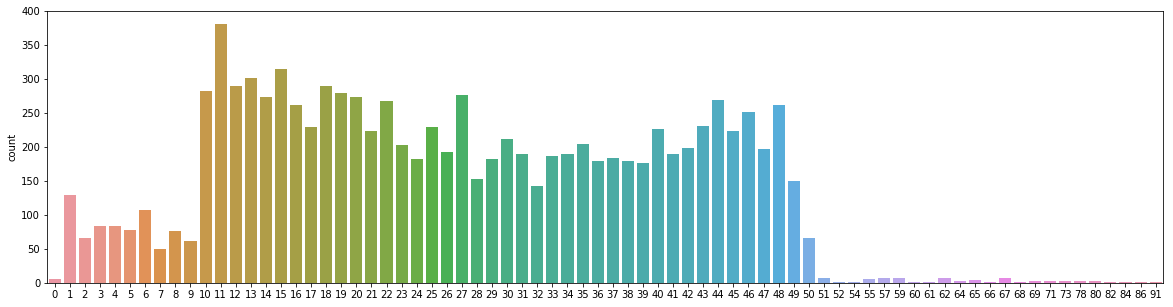

In [258]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.countplot(n1)

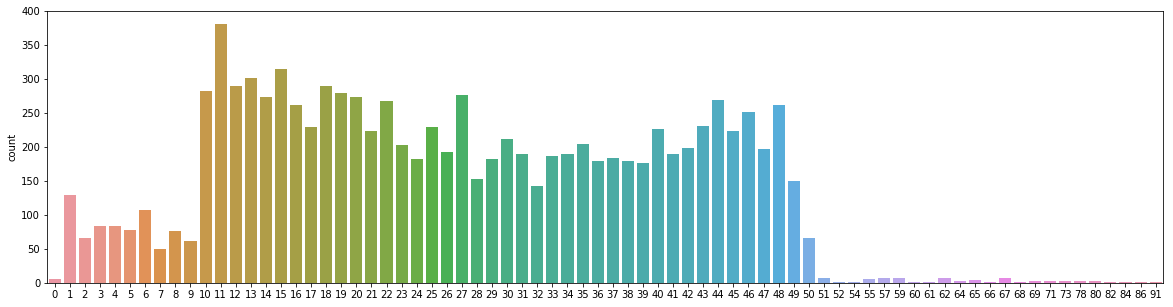

In [259]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.countplot(n2)

In [260]:
def get_n_tags(rdd,n):
    dropped=rdd.filter(lambda x: (len(x[1]))>=n).filter(lambda x:(len(x[2]))>=n)
    cutted=dropped.map(lambda x:(x[0],x[1][:n],x[2][:n],x[3]))
    return cutted

In [261]:
cut=get_n_tags(full,30)
d=cut.collect()
print("ratio is" ,100*float(len(d))/float(len(c)),"%")

('ratio is', 41.74, '%')


In [262]:
n1,n2=get_terms_by_song(r)

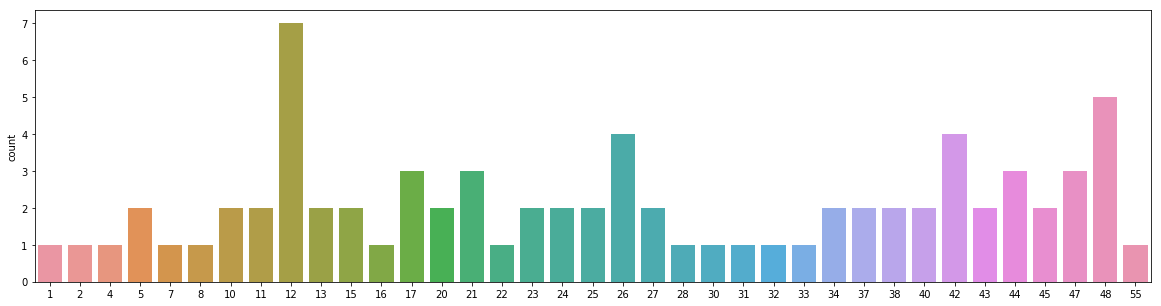

In [263]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.countplot(n2)

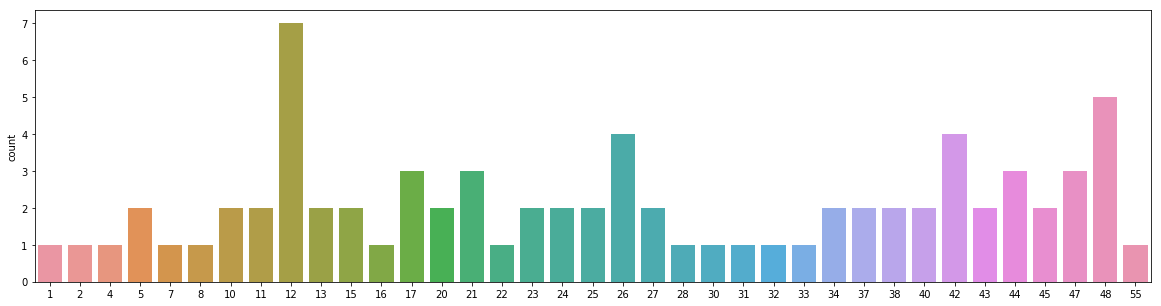

In [264]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.countplot(n1)

In [265]:
d=count_tags_weight(full)

In [266]:
most_freq=d[:50]
lst=[]
for i in most_freq:
    lst.append(i[0])
lst

['rock',
 'pop',
 'electronic',
 'jazz',
 'hip hop',
 'pop rock',
 'united states',
 'alternative rock',
 'blues',
 'folk',
 'alternative',
 'classic rock',
 'soul',
 'funk',
 'punk',
 'country',
 'american',
 'soundtrack',
 'indie',
 'reggae',
 'hard rock',
 'downtempo',
 'easy listening',
 'singer-songwriter',
 'disco',
 'rap',
 'world',
 'indie rock',
 'experimental',
 'latin',
 'guitar',
 'electro',
 'acoustic',
 'male vocalist',
 'metal',
 'ballad',
 'ambient',
 'house',
 'instrumental',
 'folk rock',
 'blues-rock',
 'techno',
 'female vocalist',
 'chill-out',
 'electronica',
 'heavy metal',
 'soft rock',
 '80s',
 'vocal',
 'hardcore']

In [272]:
def get_vector(rdd, terms):
    return rdd.map(lambda x:(x[4],[i in terms for i in x[1]]))

In [273]:
g=get_vector(full,lst)

In [274]:
c=g.collect()

In [275]:
c

[('TRAOOGD128F92E4768',
  [False,
   False,
   True,
   True,
   True,
   True,
   False,
   False,
   True,
   True,
   False,
   True,
   False,
   True,
   False,
   False,
   True,
   False,
   True,
   False,
   False,
   False,
   False]),
 ('TRAZKOL128F4234128',
  [False,
   False,
   False,
   False,
   True,
   False,
   True,
   False,
   True,
   False,
   False,
   False,
   True,
   False,
   False,
   False,
   True,
   False,
   True,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False]),
 ('TRAIYYA128F92E5A59',
  [False,
   True,
   True,
   True,
   False,
   True,
   True,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   True]),
 ('TRANRGK128F932D48F',
  [False,
   False,
   False,
   False,
   True,
   True,
   True,
   False,
   True,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   F